# 0 Demonstrating the main function calls we use during feature extraction 

A useful set of simple examples to show how to call the models and parse the data they return.

## 0.1 Demo data

Where will we find videos, images and audio for our examples?

In [1]:
import os

demo_data = r"..\data\demo"

#a couple of videos for testing
VIDEO_FILE  = os.path.join(demo_data, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
VIDEO_FILE2 = os.path.join(demo_data, "2UWdXP.joke2.rep1.take1.NomNomNom.mp4")

AUDIO_FILE = os.path.join(demo_data, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
AUDIO_FILE2 = os.path.join(demo_data, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")

IMAGE1 = os.path.join(demo_data, "mother-and-baby.jpg")
IMAGE2 = os.path.join(demo_data, "peekaboo.png")
IMAGE3 = os.path.join(demo_data, "twopeople.jpg")

videoset = [VIDEO_FILE, VIDEO_FILE2] 
audioset = [AUDIO_FILE, AUDIO_FILE2] 
photoset = [IMAGE1, IMAGE2, IMAGE3]


## 0.1 YOLOv8

Go to [docs.ultralytics.com](https://docs.ultralytics.com/) for detailed documentation and lots of examples. We just demo a few here.


In [22]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import utils   # local utils.py contains some helper functions
import display # local display.py contains display helper functions

### 0.1.1 Pose estimation

In [13]:
#get yolo model with pose estimation
model = YOLO('yolov8n-pose.pt')

results = model(IMAGE3)

print(results)


image 1/1 c:\Users\cas\OneDrive\LegoGPI\babyjokes\code\..\data\demo\twopeople.jpg: 448x640 2 persons, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 10.0ms postprocess per image at shape (1, 3, 448, 640)


[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: ultralytics.engine.results.Keypoints object
masks: None
names: {0: 'person'}
orig_img: array([[[246, 242, 241],
        [246, 242, 241],
        [246, 242, 241],
        ...,
        [241, 237, 236],
        [241, 237, 236],
        [241, 237, 236]],

       [[246, 242, 241],
        [246, 242, 241],
        [246, 242, 241],
        ...,
        [241, 237, 236],
        [241, 237, 236],
        [241, 237, 236]],

       [[246, 242, 241],
        [246, 242, 241],
        [246, 242, 241],
        ...,
        [241, 237, 236],
        [241, 237, 236],
        [241, 237, 236]],

       ...,

       [[126, 133, 136],
        [127, 134, 137],
        [127, 134, 137],
        ...,
        [107, 114, 123],
        [107, 114, 123],
        [107, 114, 123]],

       [[126, 133, 136],
        [126, 133, 136],
        [127, 134, 137],
        ...,
        [110, 117, 126],
        

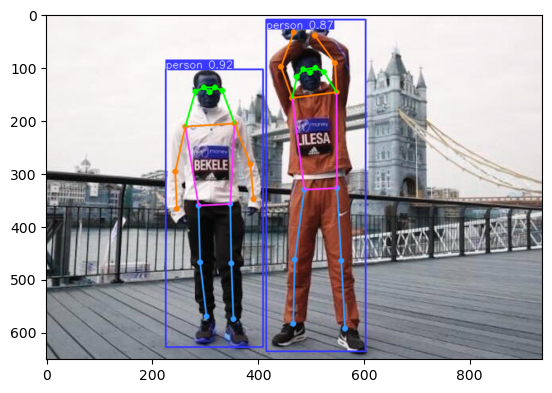

tensor([[[309.7644, 147.4411],
         [319.5117, 138.0268],
         [298.7419, 138.7523],
         [333.8133, 144.3070],
         [282.2679, 146.6327],
         [356.8875, 206.8989],
         [263.7287, 212.7963],
         [386.5011, 283.6439],
         [244.9801, 297.8372],
         [392.5638, 349.9129],
         [247.8511, 367.2190],
         [348.6078, 358.8414],
         [288.8249, 361.1242],
         [350.7739, 470.7573],
         [291.1194, 468.9760],
         [354.6002, 575.1646],
         [303.5281, 570.9740]],

        [[499.6732, 110.2885],
         [509.2666, 101.5181],
         [486.7966, 104.7825],
         [525.1655, 109.1868],
         [474.2831, 118.1297],
         [549.2231, 147.3862],
         [465.1666, 158.2237],
         [546.9080,  92.6593],
         [444.5611,  99.3642],
         [508.2557,  40.8918],
         [468.3344,  34.4887],
         [550.8055, 328.0462],
         [488.7794, 331.7028],
         [558.0571, 465.1444],
         [470.7517, 463.2544],
      

In [20]:
#automatically display image overlayed with keypoints, skeleton and bounding boxes
labelledimage = results[0].plot()
plt.imshow(labelledimage)
plt.show()

#get the keypoints as a numpy arrays of x,y coordinates each with a confidence score.
#note yolo returns tensors so we have to convert to numpy
keypoints = results[0].keypoints.cpu().numpy()
print(keypoints.xy)
print(keypoints.conf)
print(keypoints.data)

In [26]:
xyc = torch.flatten(keypoints.data[0]).tolist()

print(xyc)

[309.7644348144531, 147.44114685058594, 0.9894695281982422, 319.5117492675781, 138.02676391601562, 0.958551824092865, 298.74188232421875, 138.75233459472656, 0.9695618152618408, 333.8133239746094, 144.30697631835938, 0.7805279493331909, 282.26788330078125, 146.63265991210938, 0.8468091487884521, 356.88751220703125, 206.89892578125, 0.996717631816864, 263.72869873046875, 212.79627990722656, 0.9981535077095032, 386.5010986328125, 283.64385986328125, 0.9809609651565552, 244.98011779785156, 297.8372497558594, 0.9903420209884644, 392.5637512207031, 349.9128723144531, 0.9685062170028687, 247.85113525390625, 367.218994140625, 0.9810907244682312, 348.6078186035156, 358.84136962890625, 0.9991661310195923, 288.8248596191406, 361.1241760253906, 0.999357283115387, 350.7738952636719, 470.7572937011719, 0.9979129433631897, 291.119384765625, 468.9759826660156, 0.9985093474388123, 354.6001892089844, 575.1646118164062, 0.9864954948425293, 303.5281066894531, 570.9739990234375, 0.9896252751350403]


## 0.1.2 model.track()

In [ ]:
#Let's test it out first

# Open the video file
video_path = VIDEO_FILE
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, persist=True)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLOv8 Tracking", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

In [ ]:
#let's have a look at the results object for video 

results = model.track(VIDEO_FILE,stream=True)  

